In [30]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

Importing data

In [2]:
db = h5py.File('SVHN_single_grey1.h5')

In [3]:
print(list(db.keys()))

['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


In [85]:
X_train = db['X_train'][:]
y_train = db['y_train'][:]
X_test = db['X_test'][:]
y_test = db['y_test'][:]
X_val = db['X_val'][:]
y_val = db['y_val'][:]

Printing X train and X Test

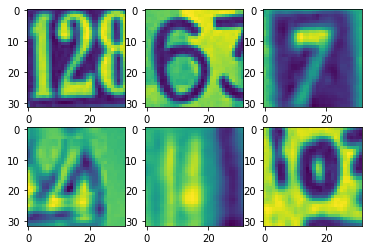

In [5]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_train[i])

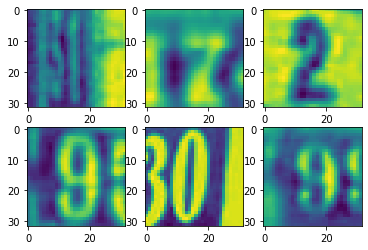

In [6]:
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[i])

Printing Y train and seeing the distribution

In [7]:
y_train

array([2, 6, 7, ..., 7, 0, 4], dtype=uint8)

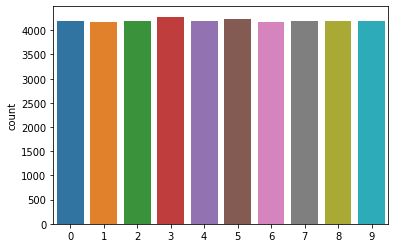

In [8]:
sns.countplot(y_train)

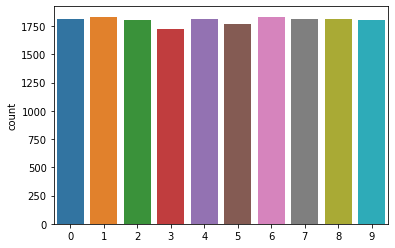

In [9]:
sns.countplot(y_test)

The distribution of classes is almost equal

Splitting the train dataset into training and validation set

In [86]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [87]:
X_train.shape

(29400, 32, 32)

In [88]:
X_val.shape

(12600, 32, 32)

Reshape data

In [89]:
X_train = np.reshape(X_train, (X_train.shape[0],-1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))

In [90]:
X_train.shape

(29400, 1024)

In [15]:
model = KNeighborsClassifier()

In [16]:
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [17]:
y_preds = model.predict(X_val)

In [18]:
y_preds

array([5, 7, 4, ..., 1, 9, 1], dtype=uint8)

In [23]:
print(classification_report(y_val, y_preds))

              precision    recall  f1-score   support

           0       0.34      0.63      0.44      1216
           1       0.40      0.67      0.51      1254
           2       0.53      0.51      0.52      1247
           3       0.45      0.40      0.42      1328
           4       0.63      0.58      0.60      1240
           5       0.46      0.34      0.39      1285
           6       0.44      0.34      0.38      1288
           7       0.71      0.55      0.62      1247
           8       0.35      0.27      0.31      1228
           9       0.50      0.34      0.41      1267

    accuracy                           0.46     12600
   macro avg       0.48      0.46      0.46     12600
weighted avg       0.48      0.46      0.46     12600



On the test set we are getting an accuracy of 46%

In [20]:
model.score(X_test, y_test)

0.46894444444444444

Checking grid search for optimum k value within 1 - 10

In [95]:
NNH = KNeighborsClassifier()

In [92]:
param_grid = {'n_neighbors':np.arange(1,10,2)}
NNH_gscv = GridSearchCV(NNH,param_grid, cv=2, scoring='accuracy')

In [93]:
NNH_gscv.fit(X_train,y_train)

GridSearchCV(cv=2, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([1, 3, 5, 7, 9])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [94]:
NNH_gscv.best_params_

{'n_neighbors': 9}

Building model with optimum k value

In [96]:
NNH_model = KNeighborsClassifier(n_neighbors=9)
NNH_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='uniform')

In [97]:
NNH_model.score(X_test, y_test)

0.4846666666666667

In [100]:
y_preds = NNH_model.predict(X_test)

In [104]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.40      0.66      0.50      1814
           1       0.43      0.69      0.53      1828
           2       0.54      0.52      0.53      1803
           3       0.38      0.39      0.39      1719
           4       0.63      0.62      0.62      1812
           5       0.44      0.35      0.39      1768
           6       0.46      0.36      0.40      1832
           7       0.71      0.57      0.63      1808
           8       0.42      0.31      0.36      1812
           9       0.54      0.37      0.44      1804

    accuracy                           0.48     18000
   macro avg       0.50      0.48      0.48     18000
weighted avg       0.50      0.48      0.48     18000



We get a slight increase in accuracy by optimizing k value to 9. A better k value might exist greater than 9 but grid search cv takes a signficant time to process it so limiting it to under 10

<strong>Artificial Neural network wih relu and without batch normalization and adam optimizer<strong>

Loading data again

In [60]:
X_train = db['X_train'][:]
y_train = db['y_train'][:]
X_test = db['X_test'][:]
y_test = db['y_test'][:]

Splitting train dataset into train and validation

In [61]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [62]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [63]:
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

Loading data again

In [35]:
X_train = db['X_train'][:]
y_train = db['y_train'][:]
X_test = db['X_test'][:]
y_test = db['y_test'][:]

In [64]:
model = Sequential()
model.add(Reshape((1024,), input_shape =(32,32,)))

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name='output'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               262400    
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 10)                5130      
Total params: 399,114
Trainable params: 399,114
Non-trainable params: 0
________________________________________________

In [65]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto')

In [66]:
callback_list = [early_stopping]

In [67]:
model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,callbacks=callback_list)

Train on 29400 samples, validate on 12600 samples
Epoch 1/100
29400/29400 [==============================] - 5s 165us/step - loss: 2.3089 - accuracy: 0.0982 - val_loss: 2.3030 - val_accuracy: 0.0984
Epoch 2/100
29400/29400 [==============================] - 5s 155us/step - loss: 2.3032 - accuracy: 0.1012 - val_loss: 2.3030 - val_accuracy: 0.0975
Epoch 3/100
29400/29400 [==============================] - 5s 156us/step - loss: 2.3030 - accuracy: 0.0995 - val_loss: 2.3027 - val_accuracy: 0.0984
Epoch 4/100
29400/29400 [==============================] - 4s 152us/step - loss: 2.3029 - accuracy: 0.0973 - val_loss: 2.3025 - val_accuracy: 0.1054
Epoch 5/100
29400/29400 [==============================] - 5s 156us/step - loss: 2.3028 - accuracy: 0.0989 - val_loss: 2.3028 - val_accuracy: 0.0975
Epoch 6/100
29400/29400 [==============================] - 4s 152us/step - loss: 2.3029 - accuracy: 0.1005 - val_loss: 2.3027 - val_accuracy: 0.0984
Epoch 7/100
29400/29400 [==============================]

In [68]:
model.evaluate(X_test, y_test)

18000/18000 [==============================] - 1s 61us/step


[2.302707233428955, 0.10066666454076767]

In [70]:
y_preds = model.predict(X_test)

In [71]:
y_pred = np.argmax(y_preds, axis = 1)
y_check = np.argmax(y_test, axis = 1)

In [72]:
print(classification_report(y_check, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1814
           1       0.00      0.00      0.00      1828
           2       0.00      0.00      0.00      1803
           3       0.00      0.00      0.00      1719
           4       0.00      0.00      0.00      1812
           5       0.00      0.00      0.00      1768
           6       0.00      0.00      0.00      1832
           7       0.00      0.00      0.00      1808
           8       0.10      1.00      0.18      1812
           9       0.00      0.00      0.00      1804

    accuracy                           0.10     18000
   macro avg       0.01      0.10      0.02     18000
weighted avg       0.01      0.10      0.02     18000



C:\Users\Suhai\Anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy is approximately 10%

model performs extremely bad without batch normalization

<strong>Artificial Neural network with relu activation and batch normalization and adam optimizer<strong>

Load data again

In [ ]:
X_train = db['X_train'][:]
y_train = db['y_train'][:]
X_test = db['X_test'][:]
y_test = db['y_test'][:]

Splitting train dataset into train and validation

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [37]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [38]:
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

In [48]:
model = Sequential()
model.add(Reshape((1024,), input_shape =(32,32,)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name='output'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_8 (Dense)              (None, 256)               262400    
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)              

In [49]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto')

In [50]:
callback_list = [early_stopping]

In [51]:
model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,callbacks=callback_list)

Train on 29400 samples, validate on 12600 samples
Epoch 1/100
29400/29400 [==============================] - 8s 270us/step - loss: 2.2959 - accuracy: 0.2735 - val_loss: 1.3143 - val_accuracy: 0.5910
Epoch 2/100
29400/29400 [==============================] - 7s 246us/step - loss: 1.5292 - accuracy: 0.4945 - val_loss: 1.0862 - val_accuracy: 0.6652
Epoch 3/100
29400/29400 [==============================] - 7s 242us/step - loss: 1.3444 - accuracy: 0.5644 - val_loss: 0.9794 - val_accuracy: 0.7087
Epoch 4/100
29400/29400 [==============================] - 7s 244us/step - loss: 1.2515 - accuracy: 0.6010 - val_loss: 0.8800 - val_accuracy: 0.7398
Epoch 5/100
29400/29400 [==============================] - 7s 243us/step - loss: 1.1958 - accuracy: 0.6171 - val_loss: 0.8554 - val_accuracy: 0.7440
Epoch 6/100
29400/29400 [==============================] - 7s 248us/step - loss: 1.1453 - accuracy: 0.6368 - val_loss: 0.8074 - val_accuracy: 0.7619
Epoch 7/100
29400/29400 [==============================]

In [59]:
model.evaluate(X_test, y_test)

18000/18000 [==============================] - 1s 81us/step


[0.5348233634630839, 0.8463888764381409]

In [52]:
y_preds = model.predict(X_test)

In [54]:
y_pred = np.argmax(y_preds, axis = 1)

In [57]:
y_check = np.argmax(y_test, axis = 1)

In [58]:
print(classification_report(y_check, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1814
           1       0.79      0.88      0.83      1828
           2       0.88      0.85      0.86      1803
           3       0.84      0.79      0.81      1719
           4       0.86      0.88      0.87      1812
           5       0.83      0.85      0.84      1768
           6       0.88      0.82      0.85      1832
           7       0.85      0.89      0.87      1808
           8       0.88      0.78      0.83      1812
           9       0.87      0.82      0.84      1804

    accuracy                           0.85     18000
   macro avg       0.85      0.85      0.85     18000
weighted avg       0.85      0.85      0.85     18000



Accuracy is 85%

Models performs exponentially better when batch normalization is used

<strong>Artificial Neural network and batch normalization with SGD<strong>

Load the data again

In [74]:
X_train = db['X_train'][:]
y_train = db['y_train'][:]
X_test = db['X_test'][:]
y_test = db['y_test'][:]

Splitting train dataset into train and validation

In [75]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)

In [76]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

In [77]:
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

In [78]:
model = Sequential()
model.add(Reshape((1024,), input_shape =(32,32,)))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name='output'))
sgd = SGD(lr=0.01, momentum=0.4, nesterov=False)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dense_12 (Dense)             (None, 256)               262400    
_________________________________________________________________
batch_normalization_6 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               131584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 512)              

In [79]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='auto')
callback_list = [early_stopping]

In [80]:
model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32,callbacks=callback_list)

Train on 29400 samples, validate on 12600 samples
Epoch 1/100
29400/29400 [==============================] - 9s 317us/step - loss: 2.2965 - accuracy: 0.2743 - val_loss: 1.3089 - val_accuracy: 0.5766
Epoch 2/100
29400/29400 [==============================] - 8s 278us/step - loss: 1.5217 - accuracy: 0.4960 - val_loss: 1.0821 - val_accuracy: 0.6764
Epoch 3/100
29400/29400 [==============================] - 8s 284us/step - loss: 1.3458 - accuracy: 0.5626 - val_loss: 0.9748 - val_accuracy: 0.7122
Epoch 4/100
29400/29400 [==============================] - 8s 279us/step - loss: 1.2555 - accuracy: 0.5954 - val_loss: 0.9045 - val_accuracy: 0.7295
Epoch 5/100
29400/29400 [==============================] - 8s 278us/step - loss: 1.1906 - accuracy: 0.6177 - val_loss: 0.8359 - val_accuracy: 0.7508
Epoch 6/100
29400/29400 [==============================] - 8s 277us/step - loss: 1.1330 - accuracy: 0.6372 - val_loss: 0.8109 - val_accuracy: 0.7595
Epoch 7/100
29400/29400 [==============================]

In [81]:
model.evaluate(X_test, y_test)

18000/18000 [==============================] - 2s 101us/step


[0.5196454910967085, 0.8457777500152588]

In [82]:
y_preds = model.predict(X_test)

In [83]:
y_pred = np.argmax(y_preds, axis = 1)
y_check = np.argmax(y_test, axis = 1)

In [84]:
print(classification_report(y_check, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1814
           1       0.75      0.90      0.82      1828
           2       0.91      0.83      0.87      1803
           3       0.84      0.78      0.81      1719
           4       0.85      0.89      0.87      1812
           5       0.85      0.85      0.85      1768
           6       0.86      0.84      0.85      1832
           7       0.85      0.89      0.87      1808
           8       0.90      0.77      0.83      1812
           9       0.82      0.82      0.82      1804

    accuracy                           0.85     18000
   macro avg       0.85      0.85      0.85     18000
weighted avg       0.85      0.85      0.85     18000



Accuracy is 85%

KNN model is significantly slower and weaker in classifying images when compared to ANN. ANN with SGD or ADAM does not make much difference in the accuracy.<br>
Image classification is better suited to be done on ANN